In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [2]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

In [3]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
nside = 16
lmax = 30
mmax = 2
kmax = 18

In [4]:
fwhm_arcmin = 5
fwhm_rad = np.radians(fwhm_arcmin/60)

# completely random beam
blm = make_full_random_alm(lmax, kmax, rng)
# ... or use a Gauss beam
#blmtmp = blm_gauss_new(fwhm_rad, lmax, True)
#blm *= 0
#blm [0:3, 0:blmtmp.shape[1]] = blmtmp

In [5]:
# completely random sky
slm = make_full_random_alm(lmax, lmax, rng)

In [6]:
pix = hp.ang2pix(nside, np.pi/2, 0) # pixel corresponding to a point on the equator
co_lat = hp.pix2ang(nside, pix)[0]  # co-latitude at the pixel's center
lon = hp.pix2ang(nside, pix)[1]     # longitude at the pixel's center

In [7]:
def fill_alm(alm, lmax, mmax):    
    # returns same as bml, but full alm_size
    alm_size = hp.Alm.getsize(lmax, mmax=mmax)
    alm_full = np.zeros((3,alm_size), dtype = np.complex128)

    idx_start = hp.Alm.getidx(lmax,0,0)
    idx_stop  = hp.Alm.getidx(lmax,lmax,0)
    alm_full[0,idx_start:idx_stop] = alm[0][idx_start:idx_stop]

    idx_start = hp.Alm.getidx(lmax,2,2)
    idx_stop = hp.Alm.getidx(lmax,lmax,2)
    alm_full[1,idx_start:idx_stop] = -alm[1][idx_start:idx_stop]
    alm_full[2,idx_start:idx_stop] = -alm[2][idx_start:idx_stop]
    
    return alm_full

bmap = hp.alm2map(fill_alm(blm,lmax=lmax,mmax=mmax),nside=nside,lmax=lmax,mmax=mmax)
norm = np.sum(bmap[0])

In [8]:
def get_beamconv_values(lmax, fwhm_arcmin, slm, ptg, hwp_angles, mueller):
    from beamconv import Beam, ScanStrategy, tools
    import qpoint as qp

    # set up beam and HWP mueller matrix (identity, i.e. no HWP)
    beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)
    beam.hwp_mueller = mueller

    nsamp = ptg.shape[0]
    duration = 1        #scan duration in seconds
    sample_rate = nsamp #samples per second

    # from (theta,phi) to (ra,dec) convention
    # also, all angles are converted in degrees
    ra = np.degrees(ptg[:,1])
    dec = 90. - np.degrees(ptg[:,0])
    psi = np.degrees(ptg[:,2])

    # calculate the quaternion
    q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

    def ctime_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        nsamp = end - start
        ctime0 = 0
        ctime = ctime0 + sample_rate*np.arange(nsamp)
        return ctime
    
    def q_bore_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        return q_bore_array[start:end]
   
    S = ScanStrategy(duration=duration, sample_rate=sample_rate, external_pointing=True, use_l2_scan=False)
    S.add_to_focal_plane(beam, combine=False)
    S.set_hwp_mod(mode='stepped', freq=sample_rate, angles=hwp_angles*180/np.pi)
    S.allocate_maps(nside=nside)
    S.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, q_bore_func=q_bore_test,
                      ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0})
    
    maps, cond, proj = S.solve_for_map(return_proj = True) 
    print(maps[:,pix])
    
    return S.data(S.chunks[0], beam=beam, data_type='tod').copy()

In [9]:
mueller0 = np.diag([1.,1.,1.,1.])
mueller1 = np.diag([1.,1.,-1.,-1.])
mueller2 = np.asarray([[1, .1, 0, 0], [.1, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]], dtype=float)

nptg=1000
ptg = np.empty((nptg,3))
ptg[:,0] = co_lat         # theta
ptg[:,1] = lon            # phi
ptg[:,2] = np.zeros(nptg) # psi

pixs = hp.ang2pix(nside, ptg[:,0], ptg[:,1])

hwp_angles = (np.arange(nptg)+6)/nptg*8*np.pi  # alpha

tod0 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller0)
tod1 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller1)
tod2 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller2)

Scanning with 1 detectors


[rank 000]:	Working on chunk 000: samples 0-1000
[-2.90391934e+00 -8.85693785e-18  8.17618433e-17]
Scanning with 1 detectors


[rank 000]:	Working on chunk 000: samples 0-1000
[  0.84247237  -3.74639171 -10.56831403]
Scanning with 1 detectors


[rank 000]:	Working on chunk 000: samples 0-1000
[  0.84247237  -3.74639171 -10.56831403]


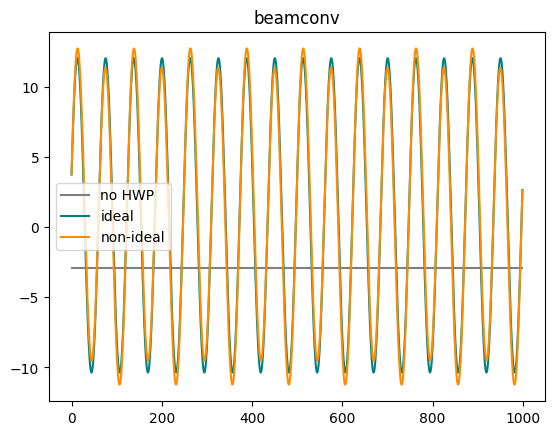

In [10]:
plt.plot(tod0, label='no HWP', color='gray')
plt.plot(tod1, label='ideal', color='teal')
plt.plot(tod2, label='non-ideal', color='darkorange')
plt.title('beamconv')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [15]:
import ducc0
import mueller_convolver

kmax = 18

# Now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller0,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)

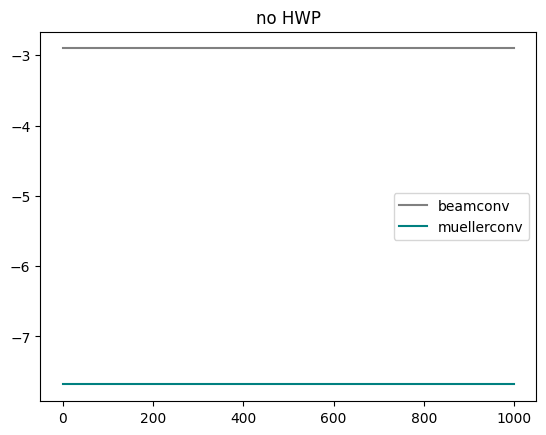

In [16]:
plt.plot(tod0, label='beamconv', color='gray')
plt.plot(signal_muellerconvolver, label='muellerconv', color='teal')
plt.title('no HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [13]:
def rot_mat(theta):
    c, s = np.cos(2*theta), np.sin(2*theta)
    return np.array(((1,0,0),(0,c,s),(0,-s,c)))

In [14]:
stokes = hp.sphtfunc.smoothing(maps, fwhm=fwhm_rad)[:,pixs[0]]

d0 = np.empty_like(tod0)
d1 = np.empty_like(tod1)
d2 = np.empty_like(tod2)

for i in np.arange(nptg):
    rot_mat_i = rot_mat(hwp_angles[i])
    stokes0 = rot_mat_i.transpose().dot(mueller0[:3,:3].dot(rot_mat_i).dot(stokes))
    d0[i] = (stokes0[0]+stokes0[1])
    stokes1 = rot_mat_i.transpose().dot(mueller1[:3,:3].dot(rot_mat_i).dot(stokes))
    d1[i] = (stokes1[0]+stokes1[1])
    stokes2 = rot_mat_i.transpose().dot(mueller2[:3,:3].dot(rot_mat_i).dot(stokes))
    d2[i] = (stokes2[0]+stokes2[1])

NameError: name 'maps' is not defined

In [ ]:
plt.plot(d0, label='no HWP', color='gray')
plt.plot(d1, label='ideal', color='teal')
plt.plot(d2, label='non-ideal', color='darkorange')
plt.title('non-convolved')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod0, label='beamconv', color='gray')
plt.plot(d0, label='non-convolved', color='teal')
plt.title('no HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod1, label='beamconv', color='gray')
plt.plot(d1, label='non-convolved', color='teal')
plt.title('ideal HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()

In [ ]:
plt.plot(tod2, label='beamconv', color='gray')
plt.plot(d2, label='non-convolved', color='teal')
plt.title('non-ideal HWP')
plt.legend()
#plt.ylim([-.1,2.1])
plt.show()